In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [153]:
!pip install fredapi > /dev/null

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_api = 'put_your_key_here'

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("fred_key")


## 1. Create The Fred Object

In [155]:
fred = Fred(api_key=secret_value_0)

## 2. Search for economic data!

In [156]:
sp_search = fred.search('S&P', order_by='popularity')

In [157]:
sp_search.head(5)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-07-12,2023-07-12,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-07-10,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-07-11 09:14:05-05:00,94,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-07-12,2023-07-12,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2023-04-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-06-27 08:13:02-05:00,90,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-07-12,2023-07-12,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-07-10,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-07-11 09:14:09-05:00,83,This data represents the effective yield of th...
SP500,SP500,2023-07-12,2023-07-12,S&P 500,2013-07-12,2023-07-11,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-07-11 19:10:52-05:00,82,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2023-07-12,2023-07-12,Real Median Household Income in the United States,1984-01-01,2021-01-01,Annual,A,2021 CPI-U-RS Adjusted Dollars,2021 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2022-09-13 13:48:01-05:00,80,Household data are collected as of March. As ...


In [158]:
sp_search.shape

(1000, 15)

## 3. Pull down raw data and plot

In [159]:
sp500 = fred.get_series(series_id = 'SP500')

<Axes: title={'center': 'S&P 500'}>

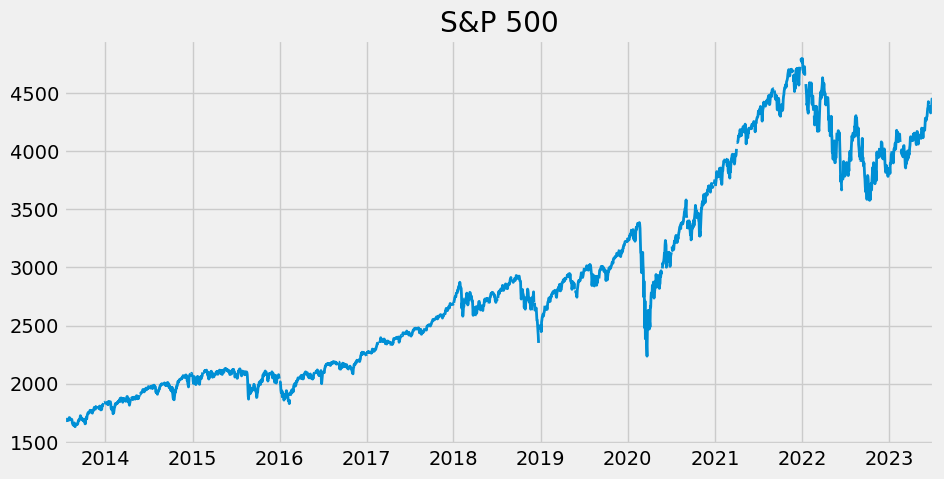

In [160]:
sp500.plot(figsize = (10, 5), title='S&P 500',lw=2)

## 4. Pull and join multiple data series

In [166]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [167]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [168]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [169]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [170]:
# Plot States Unemployment Rate
px.line(uemp_states)

## Pull 2020 Unemployment Rate Per State

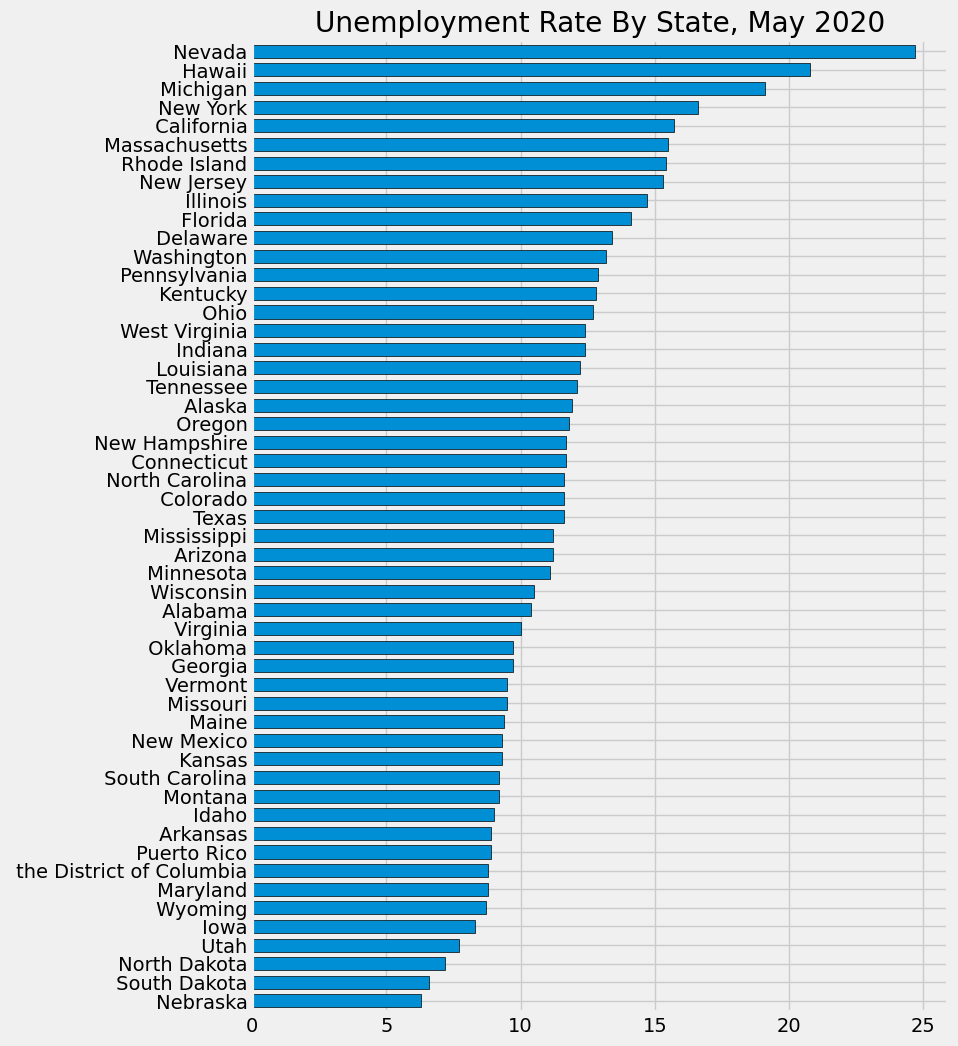

In [93]:
ax = unemp_states.loc[unemp_states.index == '2020-05-01'].T \
.sort_values('2020-05-01') \
.plot(kind='barh', figsize=(8, 12 ),width = 0.7,edgecolor ='black',
      title = 'Unemployment Rate By State, May 2020')

ax.legend().remove()
plt.show()


## Pull Participation Code

In [173]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [208]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

## Plot unemployment vs participation rate

In [176]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

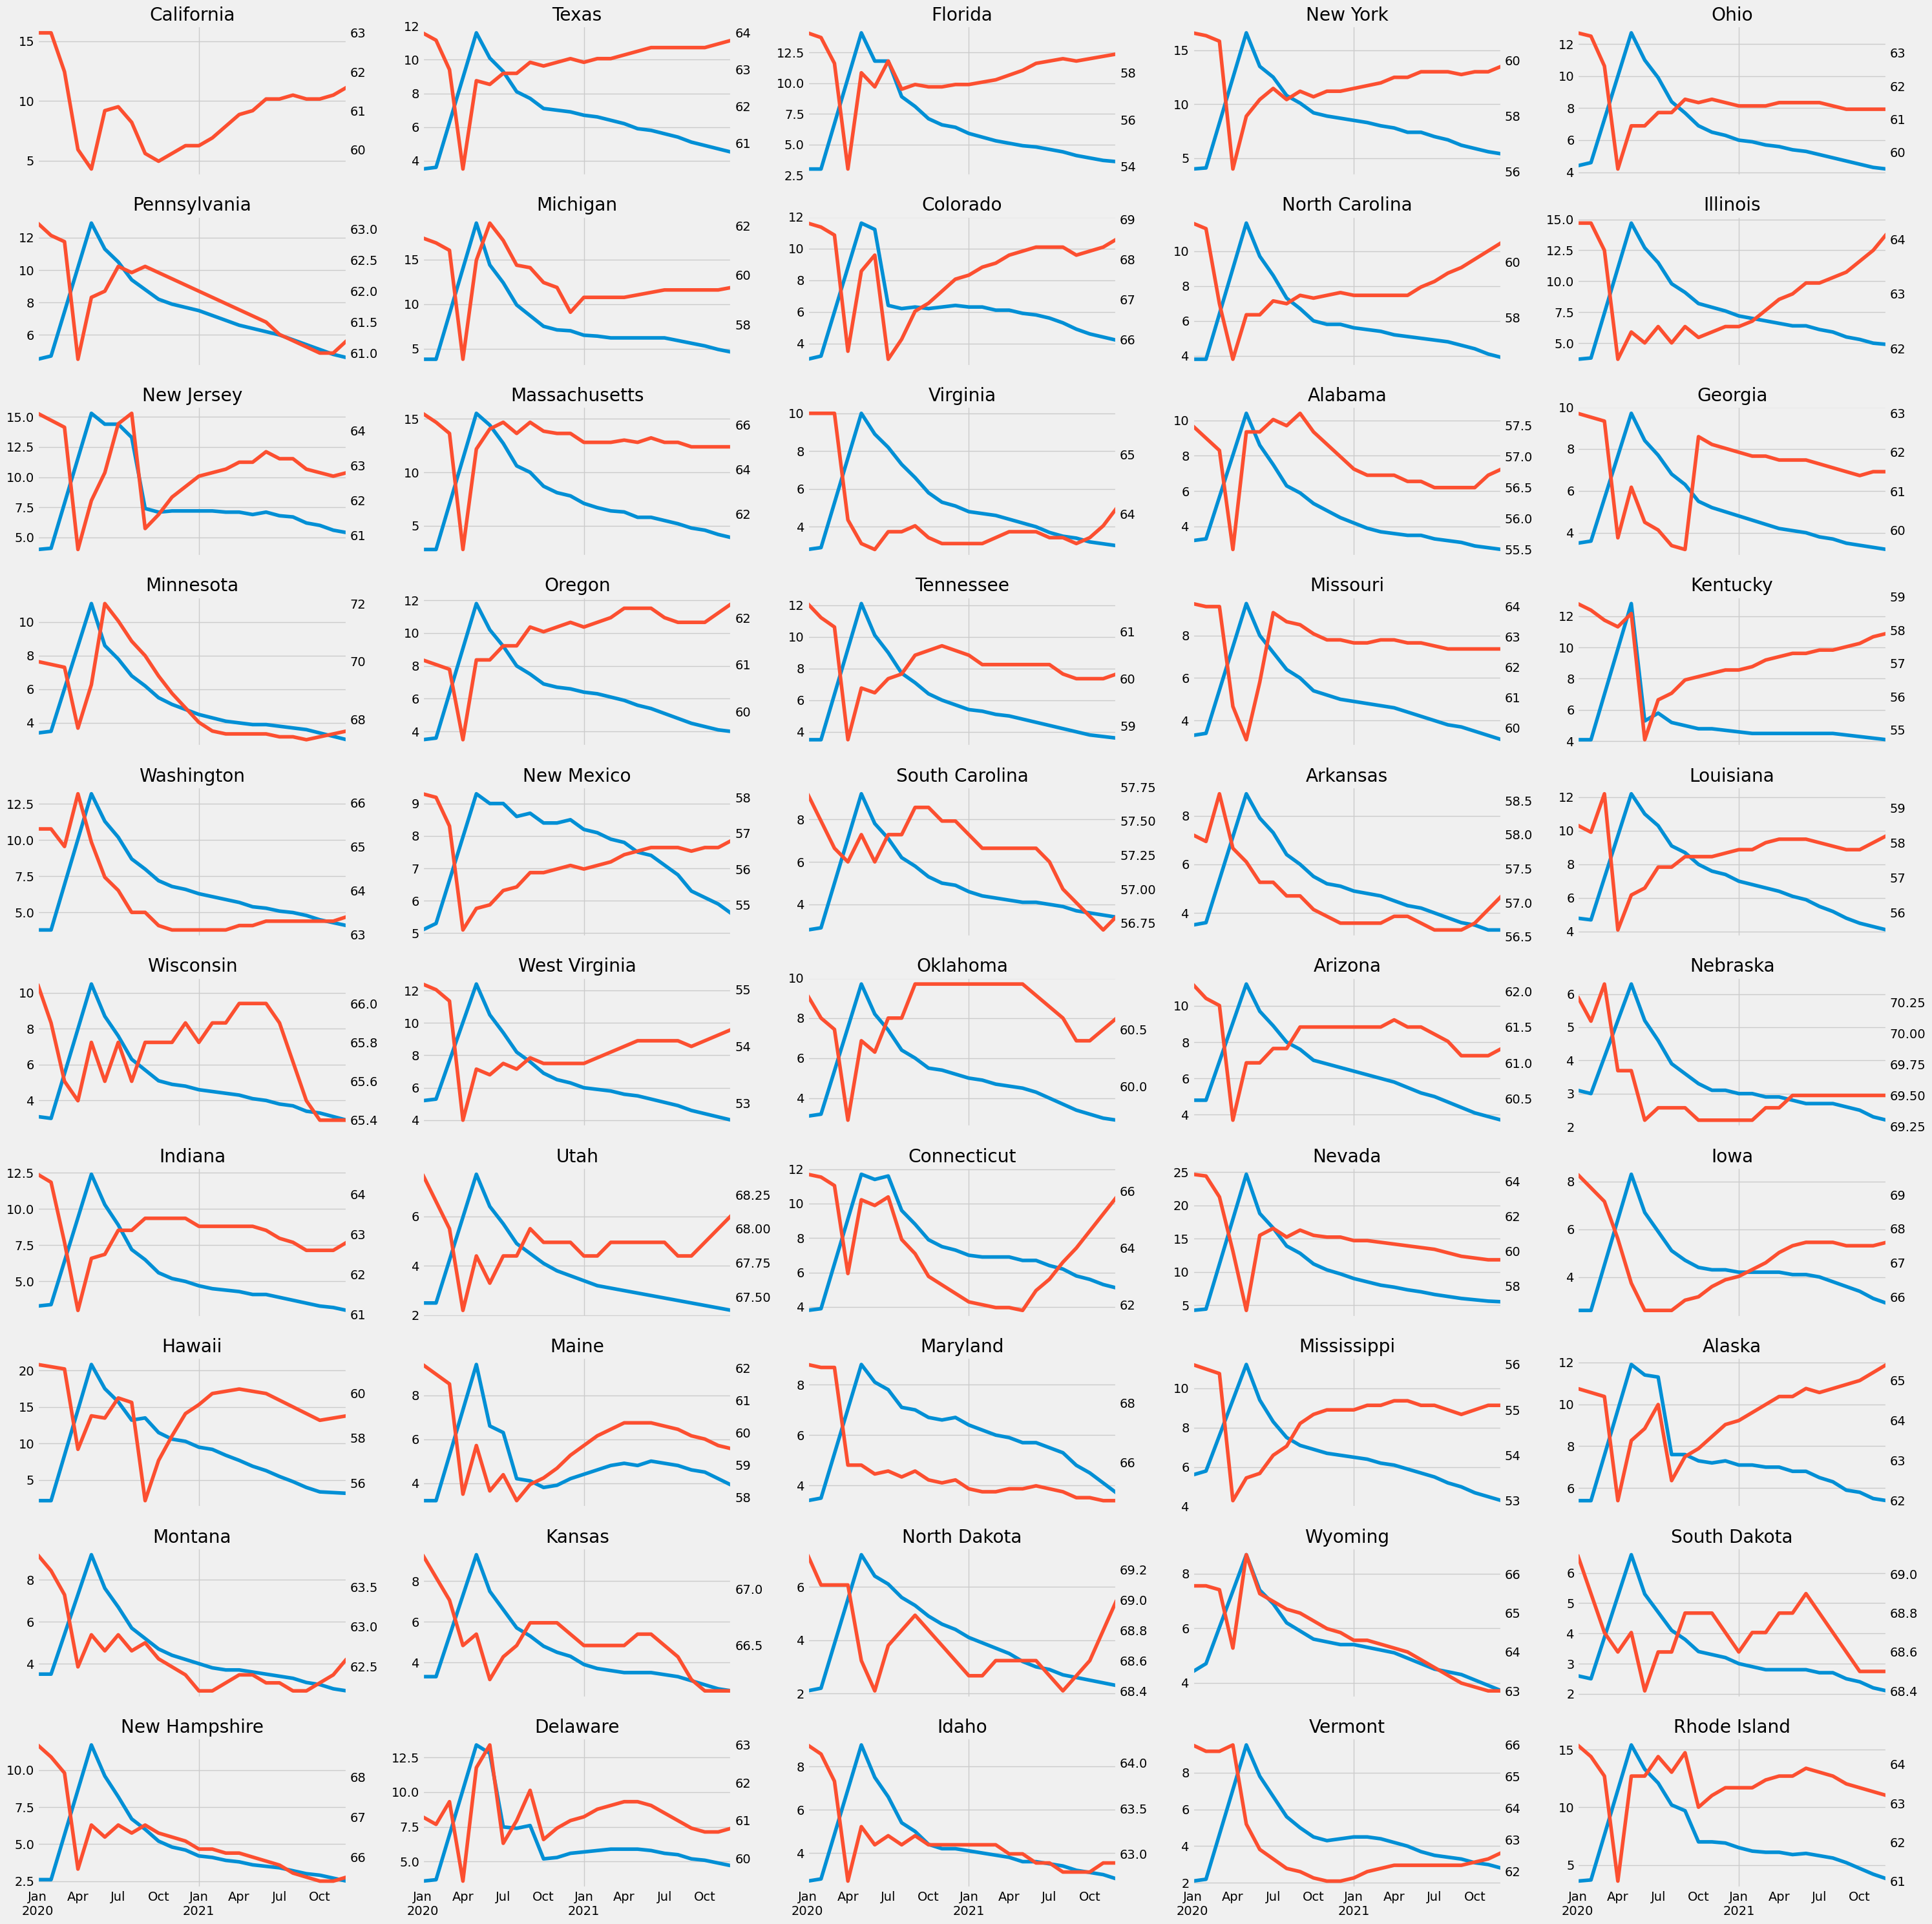

In [177]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()